TASK-1 LSTM vs. Simple Moving Average vs. Exponential Moving Average for Stock Price Prediction

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import keras as keras


In [17]:
netflix_df = pd.read_csv("netflix.csv")
print(netflix_df.columns)

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')


In [20]:
netflix_df['Date'] = pd.to_datetime(netflix_df['Date'])

In [25]:
netflix_df = netflix_df.sort_values('Date')

In [28]:

prices = netflix_df['Close']

In [32]:
window_size = 50
netflix_df['SMA'] = prices.rolling(window=window_size).mean()
netflix_df['EMA'] = prices.ewm(span=window_size, adjust=False).mean()

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices.values.reshape(-1, 1))

In [35]:
train_size = int(len(scaled_prices) *0.8)
train, test = scaled_prices[:train_size], scaled_prices[train_size:]

In [37]:
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [42]:
time_step = 50
X_train, Y_train = create_dataset(train,time_step)
X_test, Y_test = create_dataset(test, time_step)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=30, batch_size=64, validation_data=(X_test, Y_test), verbose=1)


Epoch 1/50
61/61 [==============================] - 12s 82ms/step - loss: 6.0203e-04 - val_loss: 0.0040
Epoch 2/50
61/61 [==============================] - 4s 64ms/step - loss: 2.9372e-05 - val_loss: 0.0016
Epoch 3/50
61/61 [==============================] - 4s 66ms/step - loss: 2.8819e-05 - val_loss: 0.0011
Epoch 4/50
61/61 [==============================] - 4s 68ms/step - loss: 2.8039e-05 - val_loss: 0.0010
Epoch 5/50
61/61 [==============================] - 4s 66ms/step - loss: 2.7273e-05 - val_loss: 0.0014
Epoch 6/50
61/61 [==============================] - 4s 67ms/step - loss: 2.5261e-05 - val_loss: 0.0013
Epoch 7/50
61/61 [==============================] - 4s 66ms/step - loss: 2.6557e-05 - val_loss: 0.0011
Epoch 8/50
61/61 [==============================] - 4s 70ms/step - loss: 2.5041e-05 - val_loss: 0.0011
Epoch 9/50
61/61 [==============================] - 4s 67ms/step - loss: 2.3573e-05 - val_loss: 0.0013
Epoch 10/50
61/61 [==============================] - 4s 67ms/step - loss

In [50]:

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


Y_train_actual = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))


29/29 [==============================] - 1s 19ms/step


In [52]:

train_rmse_lstm = sqrt(mean_squared_error(Y_train_actual, train_predict))
test_rmse_lstm = sqrt(mean_squared_error(Y_test_actual, test_predict))


sma_rmse = sqrt(mean_squared_error(prices[window_size:], netflix_df['SMA'][window_size:]))
ema_rmse = sqrt(mean_squared_error(prices[window_size:], netflix_df['EMA'][window_size:]))

print(f'SMA RMSE: {sma_rmse}')
print(f'EMA RMSE: {ema_rmse}')
print(f'LSTM Train RMSE: {train_rmse_lstm}')
print(f'LSTM Test RMSE: {test_rmse_lstm}')


SMA RMSE: 15.180171807523198
EMA RMSE: 13.373111315231661
LSTM Train RMSE: 1.8965501556857671
LSTM Test RMSE: 12.25223674015278


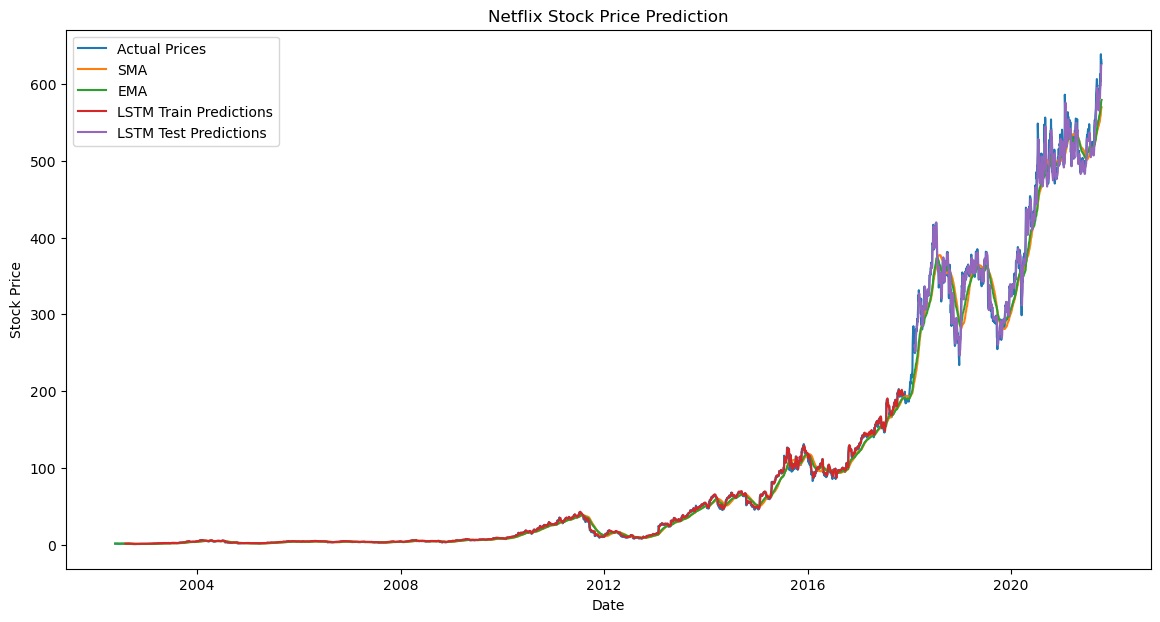

In [54]:

plt.figure(figsize=(14, 7))
plt.plot(prices.index, prices, label='Actual Prices')
plt.plot(netflix_df.index, netflix_df['SMA'], label='SMA')
plt.plot(netflix_df.index, netflix_df['EMA'], label='EMA')
plt.plot(prices.index[time_step:len(train_predict) + time_step], train_predict, label='LSTM Train Predictions')
plt.plot(prices.index[len(train_predict) + (time_step * 2) + 1:len(prices) - 1], test_predict, label='LSTM Test Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Netflix Stock Price Prediction')
plt.legend()
plt.show()


In [66]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt


TASK-2 ARIMA Model vs SARIMA for netflix Sales

In [67]:
print(netflix_df.head())

               Close
Date                
2002-05-23  1.196429
2002-05-24  1.210000
2002-05-25  1.210000
2002-05-26  1.210000
2002-05-27  1.210000


In [68]:
netflix_df = netflix_df[['Close']]
netflix_df = netflix_df.asfreq('D')
netflix_df = netflix_df.fillna(method='ffill')


C:\Users\loges\AppData\Local\Temp\ipykernel_26528\2239594304.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  netflix_df = netflix_df.fillna(method='ffill')


In [69]:
train_size = int(len(netflix_df) * 0.8)
train, test = netflix_df[:train_size], netflix_df[train_size:]
print("\nTraining ARIMA Model...")
arima_model = ARIMA(train['Close'], order=(5, 1, 0))  
arima_fit = arima_model.fit()
print(arima_fit.summary())


Training ARIMA Model...
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5665
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8808.948
Date:                Mon, 17 Mar 2025   AIC                          17629.897
Time:                        22:27:05   BIC                          17669.748
Sample:                    05-23-2002   HQIC                         17643.776
                         - 11-24-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0245      0.006      3.872      0.000       0.012       0.037
ar.L2          0.0201      0.008      2.522      0.012       0.004       0.036
ar.L3          0.0468      

In [79]:
arima_forecast = arima_fit.forecast(steps=len(test))
print("\nTraining SARIMA Model...")
sarima_model = SARIMAX(train['Close'], order=(5, 1, 0), seasonal_order=(1, 1, 1, 30))
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())
sarima_forecast = sarima_fit.forecast(steps=len(test))


Training SARIMA Model...
                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                 5665
Model:             SARIMAX(5, 1, 0)x(1, 1, [1], 30)   Log Likelihood               -8823.376
Date:                              Mon, 17 Mar 2025   AIC                          17662.753
Time:                                      22:39:54   BIC                          17715.845
Sample:                                  05-23-2002   HQIC                         17681.249
                                       - 11-24-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0295      0.006      4.638      0.000       0.017      

In [80]:
def calculate_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

arima_rmse = calculate_rmse(test['Close'], arima_forecast)
sarima_rmse = calculate_rmse(test['Close'], sarima_forecast)

print(f"ARIMA RMSE: {arima_rmse}")
print(f"SARIMA RMSE: {sarima_rmse}")
print(f"RMSE Difference: {abs(arima_rmse - sarima_rmse)}")


ARIMA RMSE: 223.30612915002382
SARIMA RMSE: 160.90398171523464
RMSE Difference: 62.402147434789185


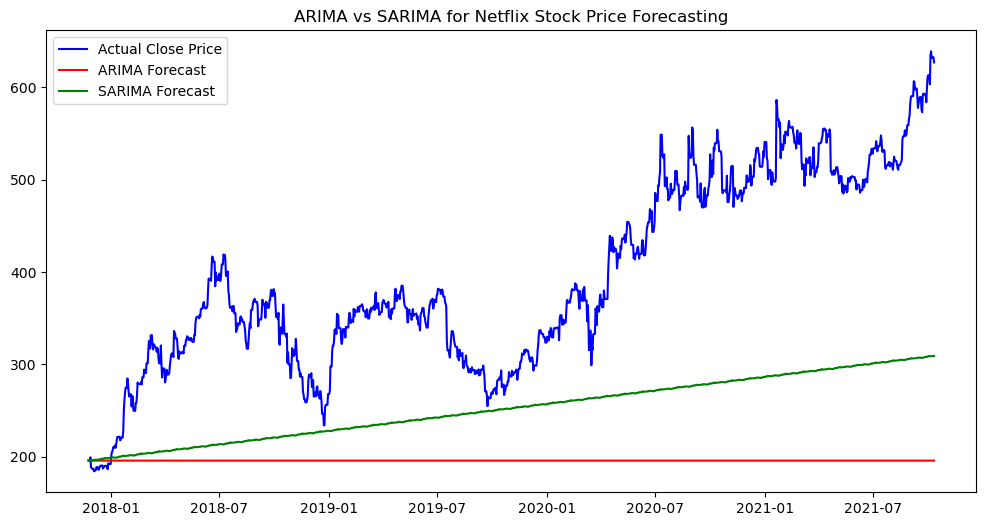

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Close'], label='Actual Close Price', color='blue')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.legend()
plt.title('ARIMA vs SARIMA for Netflix Stock Price Forecasting')
plt.show()

In [88]:
netflix_df1 = pd.read_csv("netflix.csv")
print(netflix_df1.columns)

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')


TASK-3 ARIMA vs LSTM for Energy Consumption Forecasting

In [114]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [116]:
netflix_df = netflix_df[['Close']]
netflix_df = netflix_df.asfreq('D')  
netflix_df = netflix_df.fillna(method='ffill') 

C:\Users\loges\AppData\Local\Temp\ipykernel_26528\1687366797.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  netflix_df = netflix_df.fillna(method='ffill')


In [117]:
train_size = int(len(netflix_df) * 0.8)
train, test = netflix_df[:train_size], netflix_df[train_size:]

In [120]:
print("\nTraining ARIMA Model...")
arima_model = ARIMA(train['Close'], order=(5, 1, 0))
arima_fit = arima_model.fit()
print(arima_fit.summary())
arima_forecast = arima_fit.forecast(steps=len(test))



Training ARIMA Model...
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5665
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8808.948
Date:                Mon, 17 Mar 2025   AIC                          17629.897
Time:                        23:05:42   BIC                          17669.748
Sample:                    05-23-2002   HQIC                         17643.776
                         - 11-24-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0245      0.006      3.872      0.000       0.012       0.037
ar.L2          0.0201      0.008      2.522      0.012       0.004       0.036
ar.L3          0.0468      

In [131]:
print("\nTraining LSTM Model...")

def create_lstm_dataset(netflix_df, time_step=1):
    X, Y = [], []
    for i in range(len(netflix_df) - time_step - 1):
        X.append(netflix_df[i:(i + time_step), 0])
        Y.append(netflix_df[i + time_step, 0])
    return np.array(X), np.array(Y)


Training LSTM Model...


In [132]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)


In [133]:
time_step = 10
X_train, Y_train = create_lstm_dataset(train_scaled, time_step)
X_test, Y_test = create_lstm_dataset(test_scaled, time_step)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [134]:

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train, Y_train, epochs=20, batch_size=32, verbose=1)
lstm_forecast = lstm_model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast)


Epoch 1/20
177/177 [==============================] - 8s 17ms/step - loss: 0.0020
Epoch 2/20
177/177 [==============================] - 3s 18ms/step - loss: 1.6204e-04
Epoch 3/20
177/177 [==============================] - 3s 16ms/step - loss: 1.6856e-04
Epoch 4/20
177/177 [==============================] - 3s 16ms/step - loss: 1.7267e-04
Epoch 5/20
177/177 [==============================] - 3s 16ms/step - loss: 1.8324e-04
Epoch 6/20
177/177 [==============================] - 3s 17ms/step - loss: 1.6533e-04
Epoch 7/20
177/177 [==============================] - 3s 17ms/step - loss: 1.5573e-04
Epoch 8/20
177/177 [==============================] - 3s 17ms/step - loss: 1.5106e-04
Epoch 9/20
177/177 [==============================] - 3s 16ms/step - loss: 1.5142e-04
Epoch 10/20
177/177 [==============================] - 3s 17ms/step - loss: 1.2815e-04
Epoch 11/20
177/177 [==============================] - 3s 17ms/step - loss: 1.7026e-04
Epoch 12/20
177/177 [==============================] - 3

In [135]:
def calculate_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
arima_rmse = calculate_rmse(test.values[:len(arima_forecast)], arima_forecast)
lstm_rmse = calculate_rmse(test.values[-len(lstm_forecast):], lstm_forecast)
print(f"ARIMA RMSE: {arima_rmse}")
print(f"LSTM RMSE: {lstm_rmse}")
print(f"RMSE Difference: {abs(arima_rmse - lstm_rmse)}")


ARIMA RMSE: 223.30612915002382
LSTM RMSE: 11.858390315074193
RMSE Difference: 211.44773883494963


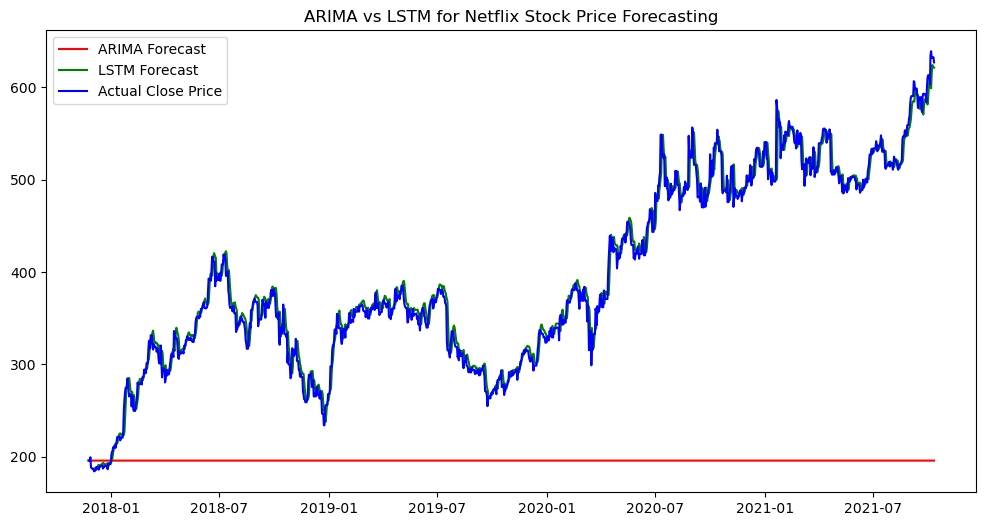

In [136]:
plt.figure(figsize=(12, 6))
plt.plot(test.index[:len(arima_forecast)], arima_forecast, label='ARIMA Forecast', color='red')
plt.plot(test.index[-len(lstm_forecast):], lstm_forecast, label='LSTM Forecast', color='green')
plt.plot(test.index, test['Close'], label='Actual Close Price', color='blue')
plt.legend()
plt.title('ARIMA vs LSTM for Netflix Stock Price Forecasting')
plt.show()
